# Predicting Mortality Risk of ICU Patients Post-CABG

<span style="color:red;"><b>
MODEL BUILDING NOTEBOOK
</span></b>

## Setting up environment and loading data

In [1]:
import deepecho
from sdv.sequential import PARSynthesizer
from sdv.metadata import Metadata

In [37]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
import keras_tuner as kt
from keras_tuner import HyperParameters, RandomSearch, Objective

In [3]:
# Set working directory
os.chdir('/sfs/gpfs/tardis/home/krb3ym/Documents/MSDS/DS6050/final_project/Predicting-Mortality-Risk-of-ICU-Patients-Post-Coronary-Artery-Bypass-Graft-Surgery/')

# Verifying GPU availability
print(tf.config.list_physical_devices('GPU'))

# Verifying tensorflow version
print(tf.__version__)

[]
2.17.0


2024-11-19 18:47:45.713096: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
# Load data
complete_final_df = pd.read_csv('./data/final_data/complete_data.csv')
imputed_final_df = pd.read_csv('./data/final_data/imputed_data.csv')

## Data Augmentation

In [5]:
df_complete = complete_final_df.drop('seq_num', axis = 1).copy()

# Creating metadata

# Auto-detecting metdata
metadata = Metadata.detect_from_dataframes(data = {'df': df_complete})
metadata.set_sequence_index(column_name='time_bucket')
metadata.update_column(column_name='mortality', sdtype='boolean')
metadata.update_column(column_name='stay_id', sdtype='id',  regex_format = "[0-9]{8}")
metadata.update_column(column_name='gcs', sdtype = 'numerical', computer_representation='Int64')
metadata.update_column(column_name='charlson', sdtype='numerical', computer_representation='Int64')
metadata.set_sequence_key(column_name='stay_id')
metadata.validate()

# Creating synethetizer
synthesizer = PARSynthesizer(
    metadata,
    enforce_min_max_values = True,
    enforce_rounding = True,
    context_columns=['anchor_age', 'gender', 'race', 'marital_status', 'insurance', 'charlson', 'mortality'],
    verbose = True,
    cuda = True,
    epochs= 512,
)

# # Adding constraints
# charlson_constraint = {
#     'constraint_class': 'ScalarRange',
#     'constraint_parameters': {
#         'column_name': 'charlson',
#         'low_value': 0,
#         'high_value': 24,
#         'strict_boundaries': False}
# }

# synthesizer.add_constraints(constraints=[charlson_constraint])

/home/krb3ym/.local/lib/python3.10/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [6]:
# Fitting synthesizer. Only run once, when needed!
# synthesizer.fit(df_complete)

# Saving synthesizer
# synthesizer = PARSynthesizer.load(
#     filepath='my_synthesizer.pkl'
# )

# Generating synethetic data from synthesizer
# synthetic_data = synthesizer.sample(num_sequences=4000)

# save the data as a CSV
#synthetic_data.to_csv('synthetic_data.csv', index=False)

In [7]:
# Loading synethesizer
synthesizer = PARSynthesizer.load(
    filepath='models/my_synthesizer.pkl'
)

# Loading synthetic data
synthetic_data = pd.read_csv('models/synthetic_data.csv')

SamplingError: This synthesizer was created on a machine with GPU but the current machine is CPU-only. This feature is currently unsupported. We recommend sampling on the same GPU-enabled machine.

In [ ]:
synthesizer.sample(num_sequences=2500)

In [ ]:
data_types = {
    'stay_id': 'categorical',           # Changed from set to string
    #'time_bucket': 'datetime',
    'anchor_age': 'continuous',
    'gender': 'categorical',
    'race': 'categorical',
    'marital_status': 'categorical',
    'insurance': 'categorical',
    'vent': 'categorical',
    'charlson': 'categorical',
    'mortality': 'categorical',
    'map': 'continuous',
    'hr': 'continuous',
    'pao2': 'continuous',
    'fio2': 'continuous',
    'creatinine': 'continuous',
    'platelets': 'continuous',
    'lactate': 'continuous',
    'gcs': 'continuous',
    'epinephrine': 'continuous',
    'norepinephrine': 'continuous',
    'phenylephrine': 'continuous',
    'dobutamine': 'continuous',
    'milrinone': 'continuous',
    'dopamine': 'continuous'
}

# Adding constraints
model.add_constraints(
    constraints=[""]
)

model = deepecho.PARModel(epochs=10, cuda=True)
model.fit(
    data=df_complete,
    data_types=data_types,
    entity_columns=['stay_id'],        # Changed to list
    context_columns=['anchor_age', 'gender', 'race', 'marital_status', 'insurance','charlson', 'mortality'],
    sequence_index='time_bucket'
)


In [ ]:
synthetic_data = model.sample(1000)
synthetic_data.head()

In [ ]:
# Number of deaths in synthetic data
synthetic_data.groupby('stay_id').mortality.any().sum()

In [ ]:
complete_final_df.race.describe()

## Model Building

In [5]:
import random
# Ensure reproducibility by setting random seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [6]:
# Creating F1 score class
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [7]:
# Create class to preprocess data
class preprocessor:
    def __init__(self, pad_length=156, seed = 42):
            # Set global seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)
        keras.utils.set_random_seed(seed)
        
        # Enable deterministic operations
        tf.config.experimental.enable_op_determinism()

        self.pad_length = pad_length
        self.label_encoders = {}
        self.numerical_scaler = StandardScaler()
        self.numerical_columns = ["anchor_age", "map", "hr", "pao2", "fio2", "gcs", "charlson",
                                "creatinine", "lactate", "platelets", "epinephrine", 
                                "norepinephrine", "phenylephrine", "dobutamine", 
                                "milrinone", "dopamine"]
        self.categorical_columns = ['insurance', 'gender', 'race', 'marital_status']
        self.binary_columns = ['vent']
        self.outcome = ['mortality']

    def fit(self, df):
        """Fit preprocessor on training data"""
        # Initialize and fit label encoders for categorical columns
        for col in self.categorical_columns:
            self.label_encoders[col] = LabelEncoder()
            self.label_encoders[col].fit(df[col].astype(str))
        
        # Fit scaler on numerical columns (reshaping for time series)
        numerical_data = df[self.numerical_columns].values
        self.numerical_scaler.fit(numerical_data)
                
        return self

    def transform(self, df):
        """Transform the data using fitted preprocessors"""
        # Transform categorical columns
        transformed_categorical = df[self.categorical_columns].copy()
        for col in self.categorical_columns:
            transformed_categorical[col] = self.label_encoders[col].transform(df[col].astype(str))

        # Stay ID
        stay_id = df['stay_id'].copy()
        
        # Scale numerical columns
        transformed_numerical = pd.DataFrame(
            self.numerical_scaler.transform(df[self.numerical_columns]),
            columns=self.numerical_columns
        )

        # Binary columns are used as-is (no transformation)
        transformed_binary = df[self.binary_columns].astype(int)
        transformed_outcome = df[self.outcome].astype(int)
        
        # Concatenate data
        transformed_data = pd.concat([stay_id, transformed_categorical, transformed_numerical, transformed_binary, transformed_outcome], axis=1)
        self.transformed_data = transformed_data
        
        # Combine transformed categorical, numerical, and binary columns
        return transformed_data

    def vectorization(self):
        """Convert transformed data to sequence vectors"""
        # Create sequences
        self.sequence_data = []
        self.sequence_labels = []
        
        for stay in self.transformed_data['stay_id'].unique():
            stay_data = self.transformed_data[self.transformed_data['stay_id'] == stay]
            features = stay_data[self.numerical_columns + self.categorical_columns + self.binary_columns].values
            label = stay_data[self.outcome].values[-1]
            
            self.sequence_data.append(features)
            self.sequence_labels.append(label)
        
        # Pad sequences
        self.sequence_data = keras.preprocessing.sequence.pad_sequences(
            self.sequence_data, 
            padding='post',
            maxlen=self.pad_length,
            value=-99
        )

        self.sequence_labels = np.array(self.sequence_labels)
        
        return self

    def train_test_split(self, size = 0.8):
        """Split data into training testing"""
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.sequence_data, self.sequence_labels, test_size=0.2, random_state=42)
        return self

    def Dataset(self, batch_size = 64):
        """Create dataset object"""
        train_df = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))
        train_df = (
            train_df
            .shuffle(buffer_size=len(self.X_train))        # Shuffle the entire dataset in memory
            .batch(batch_size)                        # Batch the data
            .prefetch(buffer_size=tf.data.AUTOTUNE)   # Prefetch batches for performance
        )
        
        val_df = tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val))
        val_df = (
            val_df
            .batch(batch_size)                        # Batch the data
            .prefetch(buffer_size=tf.data.AUTOTUNE)   # Prefetch batches for performance
        )

        return train_df, val_df


In [8]:
preprocess = preprocessor()

# Encoding data
preprocess.fit(complete_final_df)
data = preprocess.transform(complete_final_df)

# Vectorization
preprocess.vectorization()

# Splitting train/test
preprocess.train_test_split()

# Creating datasets
train, val = preprocess.Dataset()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [9]:
# Extract the shape of the input data from the Dataset
for X_batch, _ in train.take(1):
    input_shape = X_batch.shape[1:]  # Exclude the batch dimension
    break

Define custom wrapper for the Keras model to use with keras tuner

In [71]:
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, class_weight=None, seed = 42):
        # Set global seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)
        keras.utils.set_random_seed(seed)
        # Enable deterministic operations
        tf.config.experimental.enable_op_determinism()

        self.seed = seed
        self.model = None
        self.best_hp = None
        self.classes_ = np.array([0, 1])  # Binary classification
        self.tuner = None
        self.class_weight = class_weight  # Store class weights
        self.callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
    )
]

    def create_model(self, hp):
        """Create the model with optional hyperparameters."""
        # Define hyperparameters
        hp_units = hp.Int('units', min_value=16, max_value=256, step = 16)
        hp_dropout = hp.Choice('dropout_rate', [0.2, 0.3, 0.4, 0.5])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Add seed to layer initialization
        initializer = tf.keras.initializers.GlorotUniform(seed=self.seed)
        
        # Defining model architecture
        model = keras.Sequential([
                    keras.layers.InputLayer(shape=((input_shape[0],input_shape[1]))),
                    keras.layers.Masking(mask_value=-99),
                    layers.LSTM(hp_units, return_sequences=False, dropout=hp_dropout, kernel_initializer=initializer, recurrent_initializer=initializer),
                    keras.layers.Dense(1, activation=None, kernel_initializer=initializer)
                ])

        # Defining metrics
        metrics = [
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc'),
            AUC(name='auprc', curve='PR'),
            F1Score(name='f1_score')
        ]

        # Use binary cross-entropy with logits
        loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Compiling model
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate), 
                     loss= loss_fn, 
                     metrics=metrics)
        return model

    def compute_class_weight(self, df):
        """
        Compute class weights automatically if not provided
        
        Args:
            train: TensorFlow dataset
        
        Returns:
            dict: Class weights
        """
        # Extract labels from the dataset
        #y_true = np.array([label.numpy() for _, label in df])
        y_true = np.concatenate([label.numpy().flatten() for _, label in df], axis=0)

        # Compute class distribution
        unique, counts = np.unique(y_true, return_counts=True)
        total_samples = len(y_true)
        
        # Compute balanced class weights
        class_weights = {
            0: total_samples / (2 * counts[0]),
            1: total_samples / (2 * counts[1])
        }
        
        return class_weights
    
    def tune(self, train, validation):
        """Hyperparameter fine tuning using random grid search"""
        # Automatically compute class weights if not provided
        if self.class_weight is None:
            self.class_weight = self.compute_class_weight(train)

        def build_model(hp):
            return self.create_model(hp)
        
        tuner = RandomSearch(
            build_model,
            objective=Objective("val_auprc", direction="max"),
            max_trials=25,
            executions_per_trial=1,
            directory='models',
            project_name='lstm_tuning_2',
            seed = 42
        )
    
        tuner.search(
            train,
            validation_data=validation,
            epochs=20,
            callbacks=self.callbacks,
            class_weight=self.class_weight  # Add class weights to search
        )
    
        # Save the best hyperparameters and model
        self.best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        self.model = tuner.get_best_models(num_models=1)[0]
        self.tuner = tuner
    
        return self.best_hp, self.model

    def retrain_best_model(self, train, validation):
        """Retrain the best model to obtain its training history."""
        if self.best_hp is None:
            raise ValueError("No hyperparameters tuned yet. Please run tune().")

        # Automatically compute class weights if not provided
        if self.class_weight is None:
            self.class_weight = self.compute_class_weight(train)
        
        # Rebuild the best model using the best hyperparameters
        best_model = self.create_model(self.best_hp)
        
        # Retrain the model and capture the history
        history = best_model.fit(
            train,
            epochs=20,  # Adjust as needed
            validation_data=validation,
            #callbacks=self.callbacks,
            verbose=1,
            class_weight=self.class_weight
        )
        return best_model, history
    
    def predict(self, df):
        """Return predicted class labels"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        logits = self.model.predict(df)  # Predict probabilities
        probabilities = tf.nn.sigmoid(logits).numpy()
        return (probabilities > 0.5).astype(int).flatten()  # Convert to binary class labels (0 or 1)
    
    def predict_proba(self, df):
        """Return probability estimates for both classes (negative and positive)"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        logits = self.model.predict(df)  # Predict probabilities
        probabilities = tf.nn.sigmoid(logits).numpy()
        return np.hstack([1 - probabilities, probabilities])  # Class 0 and Class 1 probabilities

    # def get_best_model_metrics(self, df):
    #     """Retrieve the performance metrics of the best tuned model."""
    #     if self.model is None:
    #         raise ValueError("No model has been trained or tuned yet.")
        
    #     # Evaluate the model
    #     metrics = self.model.evaluate(df, verbose=0)
    
    #     # Format metrics as a dictionary
    #     return {name: value for name, value in zip(self.model.metrics_names, metrics)}
    
    def accuracy(self, df):
        """Return accuracy score"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        # Extract true labels
        y_true = np.array([label.numpy() for _, label in df])  # Convert from TensorFlow dataset to NumPy
        y_pred = self.predict(df)
        return accuracy_score(y_true, y_pred)

Instantiate the model wrapper, define the parameters for grid tuning, and conduct RandomizedSearchCV to tune hyperparameters

In [72]:
# Initiate Wrapper
wrapper = KerasModelWrapper()
# Fine tune the model with training and validation set
best_hp, best_model = wrapper.tune(train, val)

Reloading Tuner from models/lstm_tuning_2/tuner0.json


/home/krb3ym/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best parameters and score

In [73]:
print(f"Best Hyperparameters: {best_hp.values}")
wrapper.model.summary()  # Show the best model architecture

Best Hyperparameters: {'units': 48, 'dropout_rate': 0.3, 'learning_rate': 0.01}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 156, 21)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48)             │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,489 (52.69 KB)

 Trainable params: 13,489 (52.69 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
best_model.evaluate(val)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9987 - auc: 0.7140 - auprc: 0.6720 - f1_score: 0.6628 - loss: 0.1364 - precision: 0.6244 - recall: 0.7143                 


[0.1376761645078659,
 0.9961734414100647,
 0.75,
 1.0,
 0.9993548393249512,
 0.8999999165534973,
 0.8571428060531616]

In [79]:
best_model.get_metrics_result()

{'accuracy': 0.9961734414100647,
 'auc': 0.9993548393249512,
 'auprc': 0.8999999165534973,
 'f1_score': 0.8571428060531616,
 'loss': 0.1376761645078659,
 'precision': 0.75,
 'recall': 1.0}

In [76]:
_, history = wrapper.retrain_best_model(train, val)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9247 - auc: 0.7059 - auprc: 0.0662 - f1_score: 0.1193 - loss: 0.5695 - precision: 0.0725 - recall: 0.3498 - val_accuracy: 0.9158 - val_auc: 0.9670 - val_auprc: 0.1513 - val_f1_score: 0.2143 - val_loss: 0.5349 - val_precision: 0.1200 - val_recall: 1.0000
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9556 - auc: 0.8045 - auprc: 0.2061 - f1_score: 0.2929 - loss: 0.3876 - precision: 0.1925 - recall: 0.6420 - val_accuracy: 0.9515 - val_auc: 0.9302 - val_auprc: 0.2993 - val_f1_score: 0.2963 - val_loss: 0.3685 - val_precision: 0.1778 - val_recall: 0.8889
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9436 - auc: 0.8246 - auprc: 0.2141 - f1_score: 0.2504 - loss: 0.3415 - precision: 0.1555 - recall: 0.6790 - val_accuracy: 0.9872 - val_auc: 0.9399 - val_auprc: 0.6500 - val_f1_score: 0.6154 - val_loss: 0.4086 - val_precision: 0.4706 - val_recall: 0.8889
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83

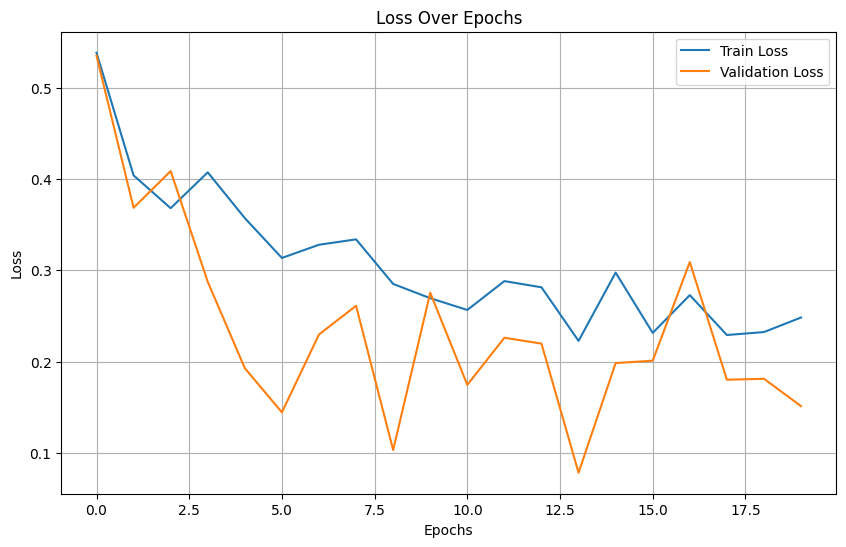

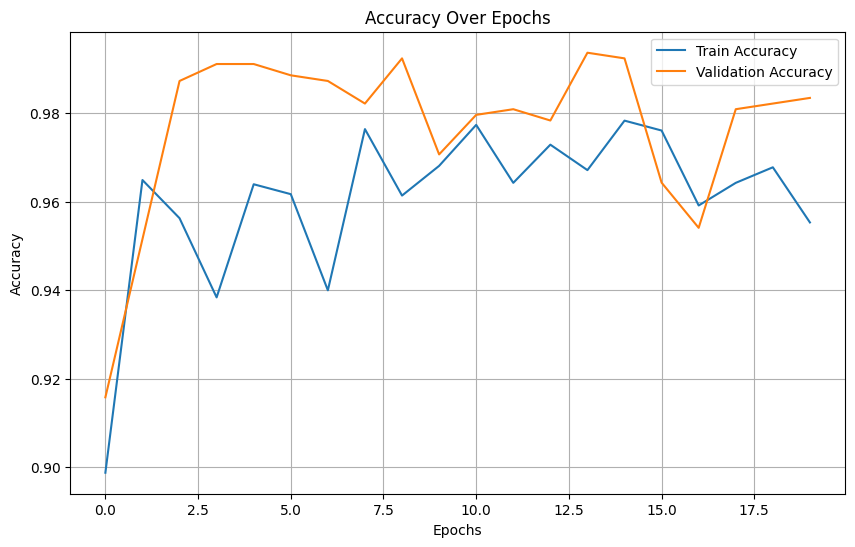

In [77]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Additional plots for other metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()
